In [2]:
from utils.card_engine import Card_Game, Card_Env, random_agent

In [72]:
import math
import random
from collections import namedtuple, deque
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt

from itertools import count

from tqdm import tqdm

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# Replay Memory

In [6]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        # save a transition
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Q network

In [8]:
class DQN(nn.Module):

    # n_input: the current state
    #  (1x52)    +  (56x52)       +       (1x52): the current state
    #    ^hand       ^who plays each card  ^cards not seen yet
    #                       + cards played
    # n_output: probability of playing each card
    #   (1x52)
    def __init__(self, n_input, n_output):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_input, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_output)

    def forward(self, x):
        if x.dtype == torch.float32:
            x = F.relu(self.layer1(x))
            x = F.relu(self.layer2(x))
        else:
            x=x.to(torch.float32)
            x = F.relu(self.layer1(x))
            x = F.relu(self.layer2(x))
        return torch.tanh(self.layer3(x))

# Training

### The network agent
Selects a move according to epsilon-greedy policy:
sometimes uses the model to select move, sometimes just select one randomally

In [16]:
'''
A single step optimization of the model using Deep Q-Learning
1) samples a batch from memory, concatenates all the tensors into a single one
2) computes Q(s_t, a_t) and V(s_{t+1}) = max_a Q(s_{t+1}, a), where s_t --(a_t)--> s_{t+1}
3) computes the loss
4) updates the target network (which is computing V(s_{t+1})) at every step with soft update
'''
def optimize_model():
    transitions = []
    for turn, mem in memory.items():
        if len(mem) >= BATCH_SIZE:
            transitions += mem.sample(BATCH_SIZE)
    if transitions == []:
        return

    # transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # mask the non final states and find the corresponding next states
    # We need an illegal move to be a non-final state
    # Right now, we are throwing out all the final states which include the case when
    # the agent ends the game prematurely after playing an illegal move


    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    # print('non_final_mask is', non_final_mask)
    non_final_next_states = [s for s in batch.next_state if s is not None]

    non_final_next_states = torch.cat(non_final_next_states)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # print('reward_batch is', reward_batch)


    # compute Q(s_t, a)
    # for each state in the batch, find the value of the corresponding action
    state_action_values = policy_net(state_batch.to(torch.float)).gather(1, action_batch)

    # compute V(s_{t+1}) = max_a Q(s_{t+1}, a) for the next_states using the target_net
    next_state_values = torch.zeros(len(transitions), device=device)
    # next_state_values = -10.0 * torch.ones(len(transitions), device=device)

    if non_final_next_states != []:

        with torch.no_grad():
            # print(non_final_mask.shape, target_net(non_final_next_states).max(1).values)
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values  # these will all be negative!

    # R + \gamma max_a Q(s', a)
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # compute the Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # back propagate
    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


In [18]:


# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
if torch.cuda.is_available():
    print("CUDA is available. GPU can be used.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")

env = Card_Env()

CUDA is available. GPU can be used.
Device name: NVIDIA GeForce GTX 1650


In [20]:
def move_to_card(move):
    return ['2','3','4','5','6','7','8','9','10','J','Q','K','A'][move % 13], ['C', 'D', 'H', 'S'][int(move / 13)]

def simulate_game(policy, verbose=False, from_move=0):
    with torch.no_grad():
        moves_played = 0
        active_player = from_move % 4
        if verbose:
            print(f"Starting new game as player {active_player} from turn {from_move}.")
        test_game = Card_Game()
        for turn in range(52):
            if test_game.current_player != active_player or turn < from_move:
                move = test_game.sample_legal_move()
            else:
                # print(policy_net(test_game.get_network_input().to(device)))
                moves_played += 1
                move = policy_net(test_game.get_network_input().to(device)).argmax().item()
                if not(move in test_game.get_legal_moves()):
                    if verbose:
                        print(f"Tried to play illegal move {move_to_card(move)}")
                    return moves_played
            if verbose:
                print(f"Player {test_game.current_player} plays {move_to_card(move)}")
            test_game.play_card(move)
            if turn % 4 == 3 and verbose:
                print()
        return moves_played

In [64]:
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 5000

BATCH_SIZE = 100
MEMORY_SIZE = 10000

# Learning rate of the optimizer
LR = 1e-4

# soft update rate
TAU = 0.005

# future discount
# GAMMA = 1.0
GAMMA = 0


state = env.game.get_network_input()

n_input = len(state)
n_actions = 52

policy_net = DQN(n_input, n_actions).to(device)
# use a target network to prevent oscillation or divergence
target_net = DQN(n_input, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
# target_net.load_state_dict(torch.load('ev_working_function.pth'))



optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = {turn: ReplayMemory(MEMORY_SIZE) for turn in range(13)}

steps_done = 0


In [66]:
'''
Given the game state, select an action by the epsilon-greedy policy
'''
def select_action(game):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    # epsilon-greedy choice

    if sample > eps_threshold:
        with torch.no_grad():
            # return the index of the card with highest probability
            # predicted from the policy net
            # print(policy_net(game.get_network_input().to(torch.float32).to(device)))
            return policy_net(game.get_network_input().to(device)).max(0).indices.view(1,1)
    else:
        # random select a legal action
        return torch.tensor([[game.sample_legal_move()]], device=device, dtype=torch.long) #changed from long


episode_durations = []
episode_rewards = []

def plot_durations_rewards(show_result=False):
    fig, ax = plt.subplots(2, 1)

    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)

    title = 'Result' if show_result else 'Training...'
    ax[0].set_title(f'{title} Duations each Episode')
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('Duration')

    ax[1].set_title(f'{title} Rewards each Episode')
    ax[1].set_xlabel('Episode')
    ax[1].set_ylabel('Reward')

    ax[0].plot(durations_t.numpy())
    ax[1].plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax[0].plot(means.numpy())

    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax[1].plot(means.numpy())

    fig.tight_layout()

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.clear_output(wait=True)
            display.display(fig)
        else:
            display.display(fig)

In [68]:
with torch.no_grad():
    print(policy_net(env.game.get_network_input().to(device)))
    print(target_net(env.game.get_network_input().to(device)))

tensor([ 0.0959, -0.0157,  0.1331,  0.0115, -0.0587,  0.0994,  0.0124, -0.0148,
         0.1164, -0.0644, -0.0866,  0.0606, -0.0642, -0.0675, -0.0392, -0.0476,
         0.0275,  0.0181,  0.0445,  0.0010, -0.0452,  0.0061,  0.0853, -0.0942,
         0.0701, -0.0207,  0.0953, -0.1132,  0.0293, -0.0199,  0.0582,  0.0673,
        -0.0294,  0.0612,  0.0518, -0.0431,  0.0453,  0.0073, -0.0360,  0.0195,
         0.0376, -0.0410,  0.0160,  0.0248,  0.0021, -0.0637, -0.0240,  0.0849,
         0.0234,  0.1145, -0.0689,  0.0738], device='cuda:0')
tensor([ 0.0959, -0.0157,  0.1331,  0.0115, -0.0587,  0.0994,  0.0124, -0.0148,
         0.1164, -0.0644, -0.0866,  0.0606, -0.0642, -0.0675, -0.0392, -0.0476,
         0.0275,  0.0181,  0.0445,  0.0010, -0.0452,  0.0061,  0.0853, -0.0942,
         0.0701, -0.0207,  0.0953, -0.1132,  0.0293, -0.0199,  0.0582,  0.0673,
        -0.0294,  0.0612,  0.0518, -0.0431,  0.0453,  0.0073, -0.0360,  0.0195,
         0.0376, -0.0410,  0.0160,  0.0248,  0.0021, -0.06

In [70]:
# fp =  DQN(n_input, 52).to(device)
# fp.load_state_dict(torch.load('latest_q_function.pth', map_location=torch.device('cpu')))

num_episodes = 10000
update_ind = 5000

save_ind = 1000

rewards_list = []
benchmark = (-9.6, 1)

for i_episode in count():
    # if i_episode % save_ind == 0 and i_episode != 0:
    #     torch.save(policy_net.state_dict(), f'/content/drive/MyDrive/deep-learning/dqn/q_fn-{i_episode}.pth')

    if i_episode % update_ind == 0 and i_episode != 0:
        # plot_durations_rewards()
        print(f"Trained {i_episode} episodes")
        avg_reward = sum(rewards_list) / len(rewards_list)
        print(f'Average reward per episode: {avg_reward}.')
        simul_results = []
        simul_dist = [0 for i in range(13)]
        for g in range(100):
            res = simulate_game(policy_net, verbose=False, from_move=random.randint(0,3))
            simul_results.append(res)
            simul_dist[res-1] += 1
        print(f"Average simulated game duration: {sum(simul_results) / 100}")
        print(f"Distribution of game lengths: {simul_dist}")
        print(f"Memory bank: {[len(mem) for i, mem in memory.items()]}")
        if benchmark[0] < avg_reward and benchmark[1] < sum(simul_results) / 100 and i_episode >= 10000:
            print("New benchmark set.")
            torch.save(policy_net.state_dict(), 'weights/ev_q_function_output.pth')
            benchmark = (avg_reward, sum(simul_results) / 100)
        rewards_list = []
        print()


    env.reset()

    player_ind = random.randint(0, 3)
    while env.game.current_player != player_ind:
        move = env.game.sample_legal_move()
        env.game.play_card(move)

    current_reward = 0
    state = torch.tensor(env.game.get_network_input(), dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
        action = select_action(env.game)
        # Select action based on policy network

        # with torch.no_grad():
        #     q_values = policy_net(state)
        #     action = q_values.max(1)[1].view(1, 1)

        # Perform action in the environment
        observation, reward, terminated = env.step(action.item(),fp=None)
        rewards_list.append(reward)
        reward = torch.tensor([reward], device=device)
        done = terminated

        current_reward += reward

        # Compute next state
        if not terminated:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        else:
            next_state = None

        # Store transition in memory
        # int(env.game.turn_counter / 4)
        memory[t].push(state, action, next_state, reward)

        # Move to next state
        state = next_state

        # Perform optimization step
        optimize_model()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            # print(f'Episode {i_episode} ended in {t} steps.')
            episode_durations.append(t+1)
            episode_rewards.append(current_reward)
            break

# plot_durations_rewards(show_result=True)

C:\Users\evarv\AppData\Local\Temp\ipykernel_17032\2810084117.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(env.game.get_network_input(), dtype=torch.float32, device=device).unsqueeze(0)
C:\Users\evarv\AppData\Local\Temp\ipykernel_17032\2810084117.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


Trained 1000 episodes
Average reward per episode: 0.524822695035461.
Average simulated game duration: 1.46
Distribution of game lengths: [63, 30, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Memory bank: [1000, 757, 558, 407, 314, 244, 192, 156, 130, 107, 87, 75, 62]

Trained 2000 episodes
Average reward per episode: 0.23165578179024202.
Average simulated game duration: 1.65
Distribution of game lengths: [60, 22, 13, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0]
Memory bank: [2000, 1422, 978, 649, 441, 315, 227, 177, 142, 113, 89, 76, 63]

Trained 3000 episodes
Average reward per episode: 0.1326973113616652.
Average simulated game duration: 1.97
Distribution of game lengths: [41, 36, 12, 7, 4, 0, 0, 0, 0, 0, 0, 0, 0]
Memory bank: [3000, 2045, 1324, 826, 529, 361, 242, 184, 145, 114, 89, 76, 63]

Trained 4000 episodes
Average reward per episode: 0.13043478260869565.
Average simulated game duration: 2.05
Distribution of game lengths: [35, 36, 19, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Memory bank: [4000, 2687, 1679, 1007, 6

KeyboardInterrupt: 

In [78]:
def save_memory(memory_file):
    with open(memory_file, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(memory, outp, pickle.HIGHEST_PROTOCOL)

save_memory('saved_memory_data.pkl')

In [80]:
def load_memory(memory_file):
    with open(memory_file, 'rb') as inp:
        return = pickle.load(inp)

memory = load_memory('saved_memory_data.pkl')

KeyboardInterrupt: 

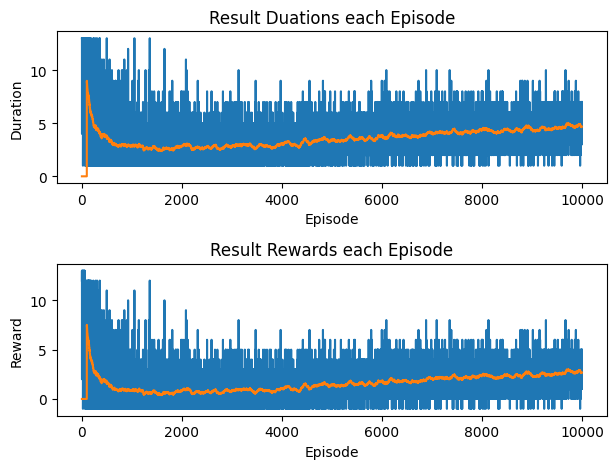

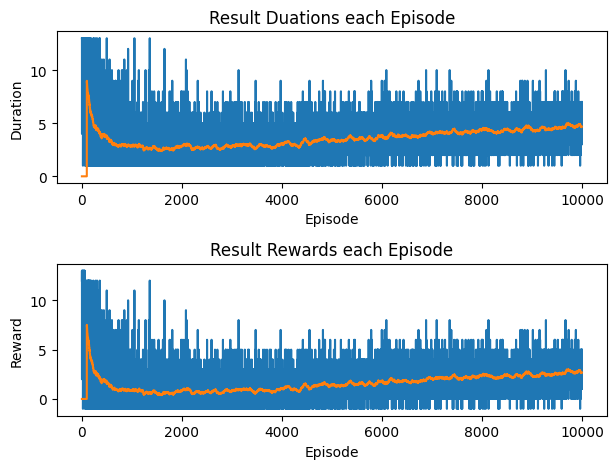

In [14]:
plot_durations_rewards(show_result=True)

In [74]:
with torch.no_grad():
    env.game.reset()
    net_input = env.game.get_network_input().to(device)
    hand = net_input[:52]
    cards = torch.arange(52).to(device)
    q_func = policy_net(net_input)
    print(f'{q_func.argmax()}')
    print(torch.stack((cards, hand, q_func)).transpose(0, 1))

32
tensor([[ 0.0000,  0.0000, -0.9812],
        [ 1.0000,  0.0000, -0.7404],
        [ 2.0000,  0.0000,  0.3696],
        [ 3.0000,  0.0000, -0.8272],
        [ 4.0000,  1.0000,  0.9999],
        [ 5.0000,  0.0000, -0.9639],
        [ 6.0000,  0.0000, -0.7162],
        [ 7.0000,  1.0000,  1.0000],
        [ 8.0000,  0.0000, -0.6829],
        [ 9.0000,  1.0000,  1.0000],
        [10.0000,  0.0000, -0.9350],
        [11.0000,  1.0000,  1.0000],
        [12.0000,  0.0000, -0.9471],
        [13.0000,  0.0000, -1.0000],
        [14.0000,  0.0000, -0.9332],
        [15.0000,  0.0000, -0.9735],
        [16.0000,  1.0000,  0.9999],
        [17.0000,  0.0000, -0.6202],
        [18.0000,  0.0000,  0.3833],
        [19.0000,  0.0000, -0.9431],
        [20.0000,  0.0000, -0.5970],
        [21.0000,  0.0000,  0.1314],
        [22.0000,  0.0000, -0.9857],
        [23.0000,  0.0000, -0.9994],
        [24.0000,  1.0000,  0.9996],
        [25.0000,  0.0000, -0.9842],
        [26.0000,  0.0000, -0.9956]

In [ ]:
torch.save(policy_net.state_dict(), 'ev_q_function_output.pth')

In [82]:
# simulate_game(policy_net, verbose=True, from_move=random.randint(0,3))
policy_net.load_state_dict(torch.load('ev_working_function.pth'))
simul_results = []
with torch.no_grad():
    simul_dist = [0 for i in range(13)]
    for g in range(1000):
        res = simulate_game(policy_net, verbose=False, from_move=random.randint(0,3))
        simul_results.append(res)
        simul_dist[res-1] += 1
    print(f"Average simulated game duration: {sum(simul_results) / 1000}")
    print(f"Distribution of game lengths: {simul_dist}")


C:\Users\evarv\Documents\Erdos\dql-trick-game\utils\card_engine.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  card = torch.nn.functional.one_hot(torch.tensor(deck_index, dtype=int), self.num_cards * self.num_players).flatten()


Average simulated game duration: 9.685
Distribution of game lengths: [9, 11, 24, 31, 37, 49, 89, 89, 93, 113, 76, 86, 293]


In [58]:
simulate_game(policy_net, verbose=True, from_move=random.randint(0, 3))

Starting new game as player 0 from turn 0.
Player 0 plays ('A', 'S')
Player 1 plays ('Q', 'S')
Player 2 plays ('9', 'S')
Player 3 plays ('8', 'S')

Player 0 plays ('J', 'C')
Player 1 plays ('Q', 'C')
Player 2 plays ('5', 'C')
Player 3 plays ('K', 'C')

Player 1 plays ('6', 'H')
Player 2 plays ('8', 'H')
Player 3 plays ('Q', 'H')
Player 0 plays ('9', 'H')

Player 3 plays ('8', 'C')
Player 0 plays ('9', 'C')
Player 1 plays ('7', 'C')
Player 2 plays ('2', 'C')

Player 0 plays ('8', 'D')
Player 1 plays ('3', 'D')
Player 2 plays ('4', 'D')
Player 3 plays ('2', 'D')

Player 0 plays ('4', 'S')
Player 1 plays ('2', 'S')
Player 2 plays ('A', 'C')
Player 3 plays ('K', 'S')

Tried to play illegal move ('4', 'S')


7